# Variational Autoencoders

In [1]:
import torch

In [2]:
device = torch.device("cuda")
torch.backends.cudnn.benchmark = True
torch.set_num_threads(12)

In [3]:
from deeptime.data import sqrt_model

dtraj, traj = sqrt_model(n_samples=10000)

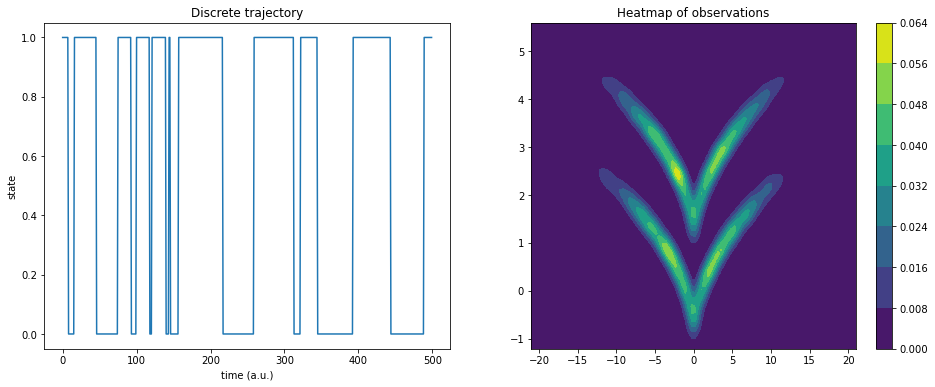

In [4]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

X, Y = np.meshgrid(
    np.linspace(np.min(traj[:, 0]), np.max(traj[:, 0]), 100),
    np.linspace(np.min(traj[:, 1]), np.max(traj[:, 1]), 100),
)
kde_input = np.dstack((X, Y)).reshape(-1, 2)

kernel = stats.gaussian_kde(traj.T, bw_method=0.1)
Z = kernel(kde_input.T).reshape(X.shape)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(dtraj[:500])
ax1.set_title("Discrete trajectory")
ax1.set_xlabel("time (a.u.)")
ax1.set_ylabel("state")

cm = ax2.contourf(X, Y, Z)
plt.colorbar(cm, ax=ax2)
ax2.set_title("Heatmap of observations");

In [5]:
from torch.utils.data import DataLoader
from deeptime.util.data import TrajectoryDataset

dataset = TrajectoryDataset(1, traj.astype(np.float32))

n_val = int(len(dataset) * 0.5)
train_data, val_data = torch.utils.data.random_split(
    dataset, [len(dataset) - n_val, n_val]
)

loader_train = DataLoader(train_data, batch_size=64, shuffle=False)
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)

In [6]:
# to make life more easy, denoise the data

In [7]:
import torch
from deeptime.util.torch import MLP

units = [2, 10, 10, 1]
encoder = MLP(
    units,
    nonlinearity=torch.nn.ReLU,
    output_nonlinearity=torch.nn.Sigmoid,
    initial_batchnorm=False,
)
decoder = MLP(units[::-1], nonlinearity=torch.nn.ReLU, initial_batchnorm=False)

In [8]:
from deeptime.decomposition.deep import TAE

tae = TAE(encoder, decoder, learning_rate=1e-3)
tae.fit(loader_train, n_epochs=30, validation_loader=loader_val)
tae_model = tae.fetch_model()

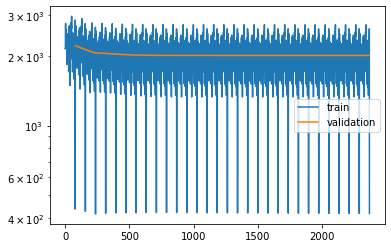

In [9]:
plt.semilogy(*tae.train_losses.T, label="train")
plt.semilogy(*tae.validation_losses.T, label="validation")
plt.legend();

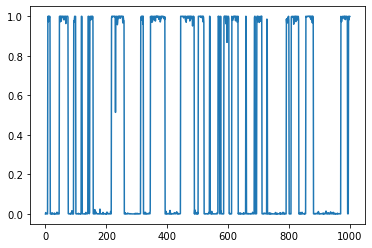

In [10]:
proj = tae_model.transform(traj)
plt.plot(proj[:1000])

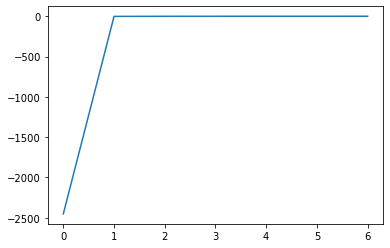

In [11]:
from sklearn.cluster import KMeans

random_state = 42
scores = []
for i in range(1, 7 + 1):
    clf = KMeans(n_clusters=i, random_state=random_state).fit(proj)
    scores.append(clf.score(proj))
plt.plot(scores)
plt.show()

# Now real data

In [12]:
import pandas as pd
import json

with open("../tests/Trajectories/ZIKV/ZIKV-Pro-427-1_dynophore_time_series.json") as f:
    data = json.load(f)
# time_ser = pd.read_json("Trajectories/ZIKV/ZIKV-Pro-427-1_dynophore_time_series.json")
time_ser = pd.DataFrame(data)
time_ser = time_ser.drop(columns="num_frames")
obs = time_ser.drop_duplicates()
num_obs = len(obs)
print("There are actually ", num_obs, " present.")
obs = obs.to_numpy()
time_ser = time_ser.to_numpy()
print("The length of the observation sequence is ", len(time_ser))

There are actually  77  present.
The length of the observation sequence is  5001


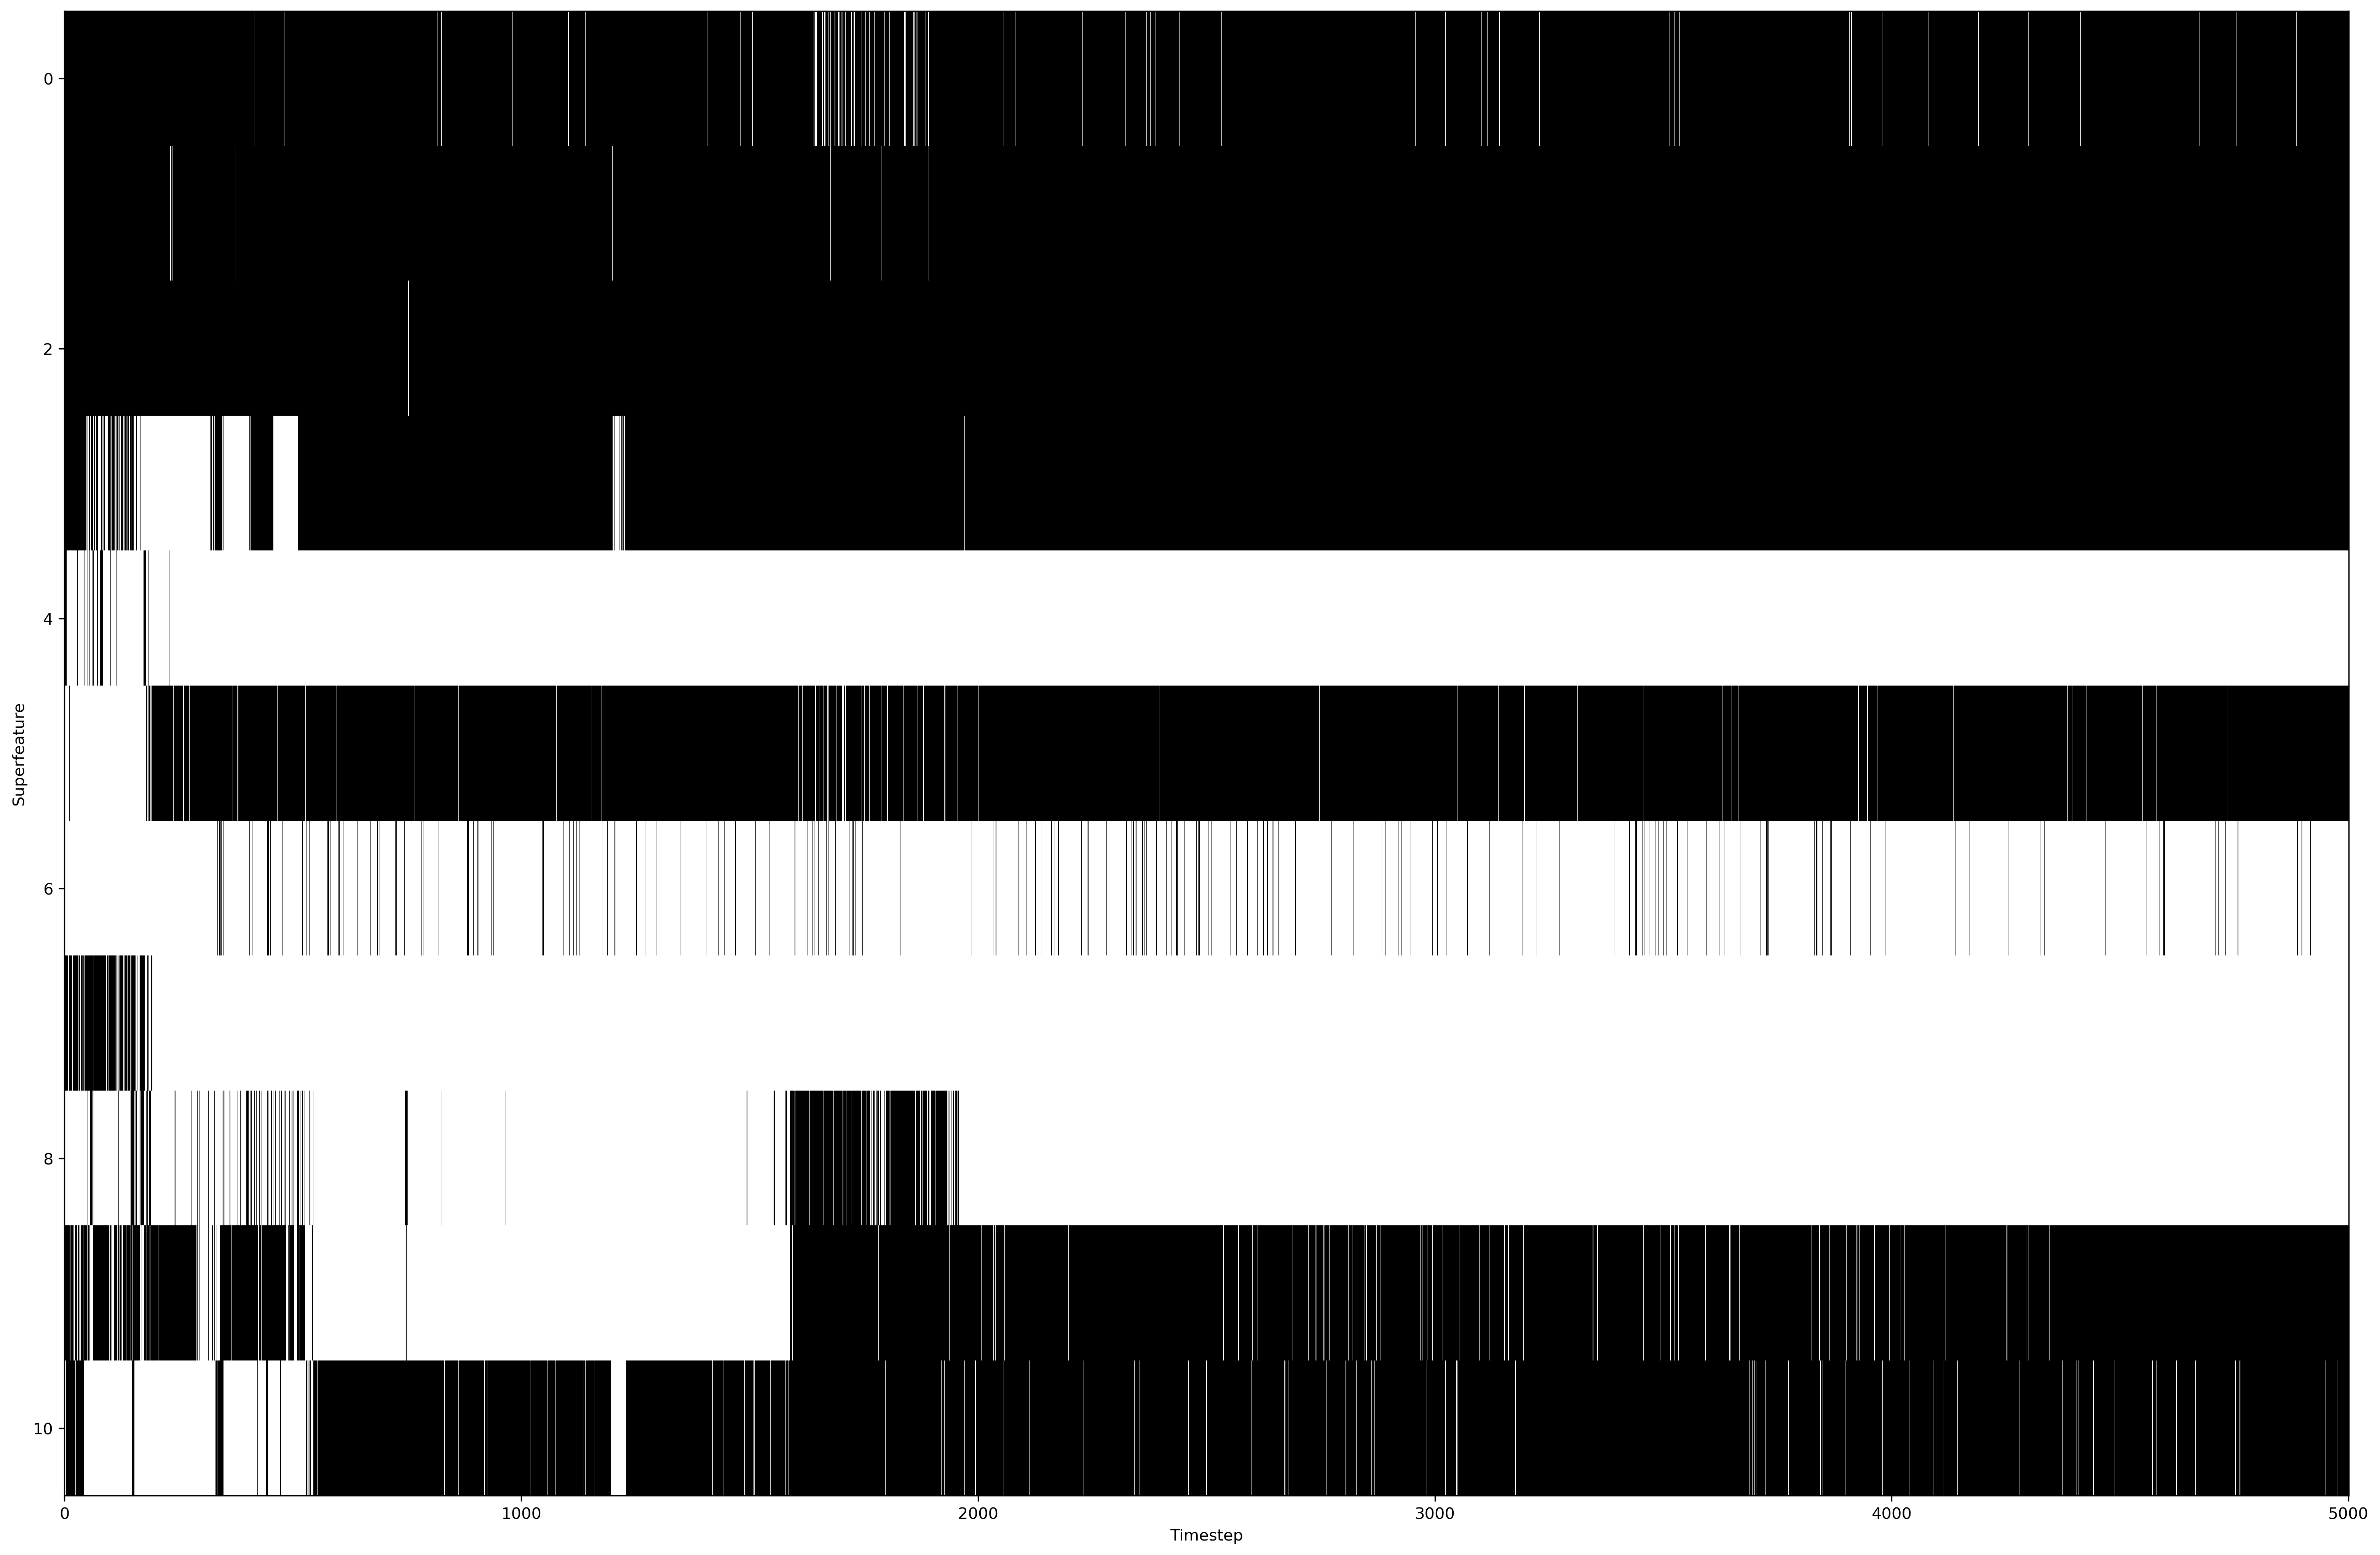

<Figure size 432x288 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt
import numpy as np


code = time_ser

pixel_per_bar = 4
dpi = 300

fig = plt.figure(figsize=(20, 13), dpi=dpi)
ax = fig.add_axes([0, 0, 1, 1])  # span the whole figure
ax.imshow(code.T, cmap="binary", aspect="auto", interpolation="nearest")
plt.xlabel("Timestep")
plt.ylabel("Superfeature")
plt.show()
plt.savefig("ZIKA_barplot_full.png")

In [14]:
time_ser = time_ser

In [15]:
dataset = TrajectoryDataset(1, time_ser.astype(np.float32))

n_val = int(len(dataset) * 0.5)
train_data, val_data = torch.utils.data.random_split(
    dataset, [len(dataset) - n_val, n_val]
)
print(len(val_data))
loader_train = DataLoader(train_data, batch_size=64, shuffle=False)
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)

2500


In [16]:
num_superfeatures = len(obs[0])

In [17]:
units = [num_superfeatures, 4 * num_superfeatures, 4 * num_superfeatures, 1]
encoder = MLP(
    units,
    nonlinearity=torch.nn.ReLU,
    output_nonlinearity=torch.nn.Sigmoid,
    initial_batchnorm=False,
)
decoder = MLP(units[::-1], nonlinearity=torch.nn.ReLU, initial_batchnorm=False)

In [18]:
tae = TAE(encoder, decoder, learning_rate=1e-3)
tae.fit(loader_train, n_epochs=50, validation_loader=loader_val)
tae_model = tae.fetch_model()

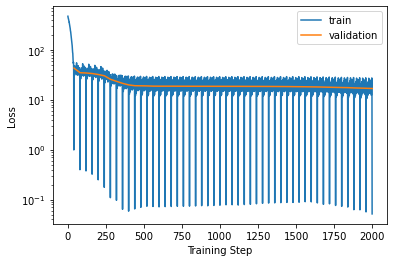

In [19]:
plt.semilogy(*tae.train_losses.T, label="train")
plt.semilogy(*tae.validation_losses.T, label="validation")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.legend();

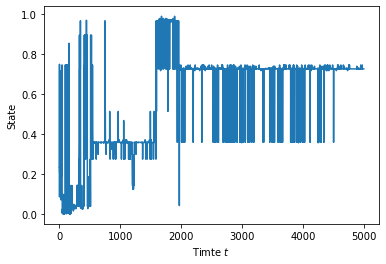

In [20]:
proj = tae_model.transform(time_ser)
plt.ylabel("State")
plt.xlabel("Timte $t$")
plt.plot(np.arange(0, len(proj), 1), proj)

# Cluster for Distinct States

In [21]:
from sklearn.cluster import KMeans
from tqdm import tqdm

random_state = 42
scores = np.zeros(16)
sum_of_squared_distances = np.zeros(16)
for i in range(1, 15):
    clf = KMeans(n_clusters=i, random_state=random_state).fit(proj)
    scores[i] = clf.score(proj)
    sum_of_squared_distances[i] = clf.inertia_

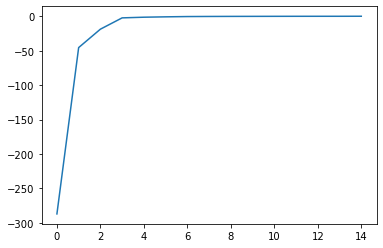

In [22]:
plt.plot(scores[1:])

In [23]:
len(np.unique(proj))
metric = np.diff(sum_of_squared_distances[1:] / sum_of_squared_distances[1:][0])

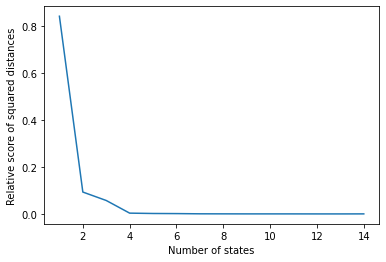

In [24]:
diff = np.abs(np.diff(sum_of_squared_distances[1:] / sum_of_squared_distances[1:][0]))
plt.plot(np.arange(1, len(diff) + 1, 1), diff)
plt.xlabel("Number of states")
plt.ylabel("Relative score of squared distances")
plt.savefig("HIV_ellbow_full.png", dpi=300)

In [25]:
metric

array([-8.41475291e-01, -9.31352627e-02, -5.71695048e-02, -3.34473395e-03,
       -1.87989285e-03, -1.41225677e-03, -5.01936084e-04, -3.10052205e-04,
       -1.75376696e-04, -1.62244599e-04, -1.49584122e-04, -5.01885539e-05,
       -3.86026509e-05, -1.95072572e-04])

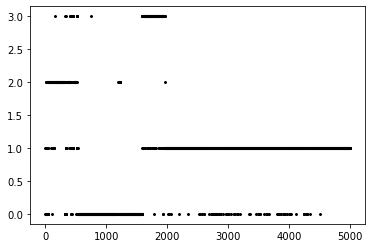

In [26]:
# get labels
clf = KMeans(n_clusters=4, random_state=random_state).fit(proj)
labels = clf.labels_
plt.scatter(np.arange(0, len(time_ser), 1), labels, marker="x", s=4, color="black")
plt.savefig("HIV_Discretized_Traj.png", dpi=300)

In [27]:
np.savetxt("HIV_labels_tae.csv", labels, delimiter=",")

## Map States to pharmacophore

In [72]:
import pandas as pd
import json

with open("../tests/Trajectories/ZIKV/ZIKV-Pro-427-1_dynophore_time_series.json") as f:
    data = json.load(f)
# time_ser = pd.read_json("Trajectories/ZIKV/ZIKV-Pro-427-1_dynophore_time_series.json")
time_ser = pd.DataFrame(data)
time_ser = time_ser.drop(columns="num_frames")
obs = time_ser.drop_duplicates()
num_obs = len(obs)
print("There are actually ", num_obs, " present.")
obs = obs.to_numpy()
time_ser = time_ser.to_numpy()
print("The length of the observation sequence is ", len(time_ser))

There are actually  77  present.
The length of the observation sequence is  5001


In [74]:
def extract_features():
    pass


np.where(time_ser[0] > 0)

(array([ 0,  1,  2,  3,  7,  9, 10]),)

In [99]:
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)
from dylightful.parser import get_env_partners

In [103]:
store = {}
env_partners = load_env_partners(
    "../tests/Trajectories/ZIKV/ZIKV-Pro-427-1_dynophore.json"
)
for i in np.unique(labels):
    store[str(i)] = []
for i in range(len(time_ser)):
    state = str(labels[i])
    state_map = store[state]
    state_map.append(np.where(time_ser[i, :] == 1)[0].astype(np.int16).tolist())
    store[state] = state_map
for state in store.keys():
    occ = np.where(labels == int(state))
    num_occ = len(occ)
    state_data = {}
    state_data["frameIndices"] = occ
    state_data["num"] = num_occ
    unique_parmc = np.unique(np.array(store[state])).tolist()
    state_data["pharmc"] = unique_parmc
    superfeats = set()
    for pharmc in unique_parmc:
        superfeats = superfeats.union(set(pharmc))
    state_data["distinctSuperfeatures"] = list(superfeats)
    indc = state_data["frameIndices"]
    env_partner_arr = []
    residues = list(env_partners.keys())
    for partner in env_partners.keys():
        env_partner_arr.append(env_partners[partner])

    env_partner_arr = np.array(env_partner_arr)
    partners = []
    for i in range(len(indc[0])):
        eps = np.array(residues)[
            np.where(env_partner_arr[:, indc][:, 0, i] == 1)[0].tolist()
        ]
        partners.append(eps)
    state_data["env_partners_list"] = partners
    count = []
    for partner in partners:
        count += partner.tolist()
    unique, counts = np.unique(count, return_counts=True)

{'frameIndices': (array([ 157,  329,  345,  408,  409,  416,  417,  420,  427,  432,  437,
          441,  444,  446,  453,  457,  512,  513,  516,  521,  526,  748,
         1589, 1590, 1591, 1592, 1595, 1596, 1597, 1598, 1600, 1602, 1603,
         1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614,
         1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1625,
         1626, 1627, 1628, 1629, 1630, 1632, 1633, 1634, 1635, 1637, 1638,
         1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649,
         1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660,
         1661, 1663, 1664, 1665, 1666, 1667, 1668, 1669, 1670, 1671, 1672,
         1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1682, 1683,
         1685, 1686, 1687, 1688, 1689, 1690, 1691, 1692, 1693, 1694, 1695,
         1696, 1697, 1698, 1699, 1700, 1701, 1703, 1705, 1706, 1707, 1708,
         1709, 1710, 1712, 1714, 1715, 1716, 1717, 1718, 1719, 1720, 1721,
         

In [162]:
indc = state_data["frameIndices"]
env_partner_arr = []
residues = list(env_partners.keys())
for partner in env_partners.keys():
    env_partner_arr.append(env_partners[partner])

env_partner_arr = np.array(env_partner_arr)
print(env_partner_arr[:, indc].shape)
partners = []
for i in range(len(indc[0])):
    eps = np.array(residues)[
        np.where(env_partner_arr[:, indc][:, 0, i] == 1)[0].tolist()
    ]
    partners.append(eps)
state_data["env_partners_list"] = partners
count = []
for partner in partners:
    count += partner.tolist()
unique, counts = np.unique(count, return_counts=True)
unique, counts

(38, 1, 331)


(array(['ALA_132_B:superFeature10', 'ALA_132_B:superFeature9',
        'ASN_152_B:superFeature1', 'ASP_75_B:superFeature1',
        'ASP_75_B:superFeature5', 'ASP_75_B:superFeature8',
        'ASP_83_A:superFeature1', 'ASP_83_A:superFeature4',
        'ASP_83_A:superFeature5', 'ASP_83_A:superFeature7',
        'GLY_151_B:superFeature1', 'GLY_153_B:superFeature2',
        'GLY_82_A:superFeature1', 'PHE_84_A:superFeature7',
        'TYR_161_B:superFeature1', 'TYR_161_B:superFeature10',
        'TYR_161_B:superFeature2', 'TYR_161_B:superFeature4',
        'TYR_161_B:superFeature9', 'VAL_154_B:superFeature9',
        'VAL_155_B:superFeature0', 'VAL_155_B:superFeature10',
        'VAL_155_B:superFeature9'], dtype='<U24'),
 array([  1,   2,  50,  37, 330, 170,  20, 330,  22, 276, 210, 193,  22,
        248,   1,   5, 246,   1, 275,   1,  20, 326, 102]))

In [98]:
env_partners = get_env_partners(
    "../tests/Trajectories/ZIKV/ZIKV-Pro-427-1_dynophore.json"
)

{'VAL_155_B:superFeature0': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0

In [77]:
import json

with open("ZIKV_state_map.json", "w") as fp:
    json.dump(store, fp)

# Fit MSM to Discretization

For HMM see: https://deeptime-ml.github.io/latest/api/generated/deeptime.markov.hmm.BayesianHMMPosterior.html#deeptime.markov.hmm.BayesianHMMPosterior

In [125]:
import numpy as np
from deeptime.markov import TransitionCountEstimator

estimator = TransitionCountEstimator(lagtime=1, count_mode="sliding")

In [126]:
counts = estimator.fit(labels).fetch_model()  # fit and fetch the model

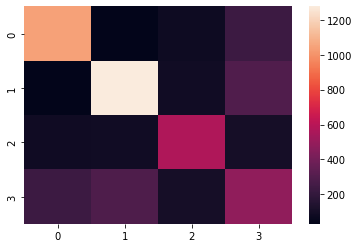

In [127]:
import seaborn as sns

ax = sns.heatmap(counts.count_matrix)
fig = ax.get_figure()
fig.savefig("HIV_count_matrix_full.png", dpi=300)

In [128]:
import deeptime.markov as markov

estimator = markov.msm.MaximumLikelihoodMSM(
    reversible=True, stationary_distribution_constraint=None
)

msm = estimator.fit(counts).fetch_model()

In [129]:
print("Estimated transition matrix:", msm.transition_matrix)
print("Estimated stationary distribution:", msm.stationary_distribution)

Estimated transition matrix: [[0.75235337 0.02389573 0.05792904 0.16582187]
 [0.01958457 0.7578635  0.05163205 0.17091988]
 [0.09535161 0.10369487 0.67938021 0.1215733 ]
 [0.20818182 0.26181818 0.09272727 0.43727273]]
Estimated stationary distribution: [0.27592408 0.33666334 0.16763237 0.21978022]


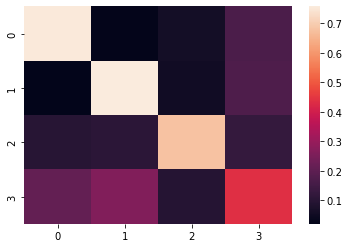

In [130]:
ax = sns.heatmap(msm.transition_matrix)
fig = ax.get_figure()
fig.savefig("HIV_tae_full.png", dpi=300)

# Fit HMM to Discretization & Raw Data
1.) Discretization of the Trajectory

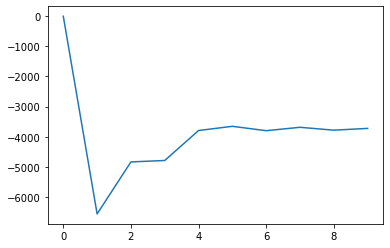

In [43]:
from hmmlearn import hmm
from sklearn.preprocessing import LabelEncoder


def calculate_probas(time_ser, model):
    probas = model.predict_proba(time_ser)
    states = model.predict(time_ser)
    return np.mean(np.linalg.norm(probas, axis=1))


num_sim = 10
scores = np.zeros(num_sim)
probas = np.zeros(num_sim)
labels = labels.reshape(-1, 1)
for i in range(1, num_sim):
    model = hmm.MultinomialHMM(n_components=i)
    try:
        pred = model.fit(labels)
        scores[i] = model.score(labels)
        probas[i] = calculate_probas(time_ser, model)
    except:
        scores[i] = 0
        probas[i] = 0
plt.cla()
plt.clf()
plt.plot(scores)

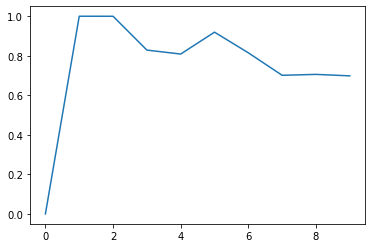

In [44]:
plt.plot(probas)

In [45]:
def proba_per_state(time_ser, model):
    """ """
    probas = model.predict_proba(time_ser)
    states = model.predict(time_ser)
    prob_ser = np.zeros(probas.shape)
    for i in range(len(states)):
        prob_ser[i, states[i]] = probas[i, states[i]]
    return prob_ser


model = hmm.MultinomialHMM(n_components=4)
labels = labels.reshape(-1, 1)
model.fit(labels)
result = model.predict(labels)
print(labels[:10])
test = proba_per_state(labels, model)[:2000]

[[3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [0]
 [3]
 [3]]


In [46]:
probas = model.predict_proba(labels)

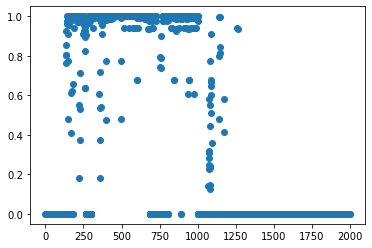

In [47]:
plt.scatter(np.arange(0, len(test), 1), test[:, 0])

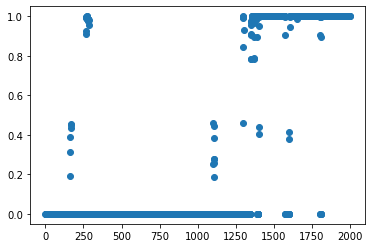

In [48]:
plt.scatter(np.arange(0, len(test), 1), test[:, 1])

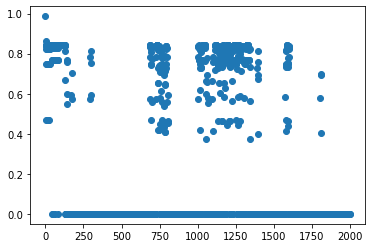

In [49]:
plt.scatter(np.arange(0, len(test), 1), test[:, 2])

In [50]:
def aic(scores):
    return -2 * scores - 2 * np.arange(1, 11, 1)

In [51]:
aic = aic(scores)

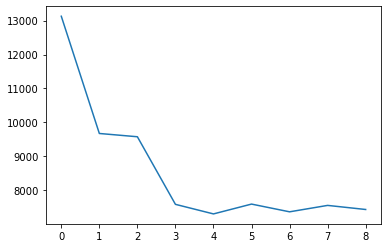

In [52]:
plt.plot(aic[1:])

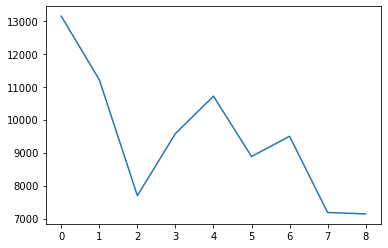

In [66]:
def bic(scores):
    return -2 * scores + np.arange(1, 11, 1) + np.log(len(scores))


bic_s = bic(scores)
plt.plot(bic_s[1:])

TypeError: 'numpy.ndarray' object is not callable

In [44]:
probas = model.predict_proba(time_ser)
np.mean(np.linalg.norm(probas, axis=1))

0.7581689692113758

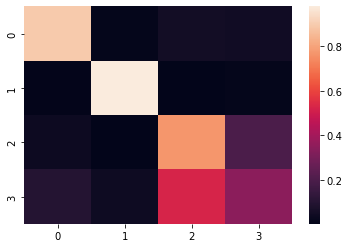

In [54]:
ax = sns.heatmap(model.transmat_)

# HMM on the whole trajectory

In [55]:
def label_traj(time_ser, obs):
    reduced_time_ser = np.zeros(len(time_ser))
    for i in range(len(time_ser)):
        for j in range(len(obs)):
            if compare_array(time_ser[i], obs[j]):
                reduced_time_ser[i] = j
                break
    return reduced_time_ser.astype(np.int64)


def compare_array(arr1, arr2):
    comp = arr1 == arr2
    return comp.all()


red_time_ser = label_traj(time_ser, obs)

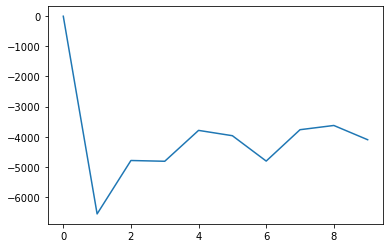

In [67]:
from hmmlearn import hmm
from sklearn.preprocessing import LabelEncoder


def calculate_probas(time_ser, model):
    probas = model.predict_proba(time_ser)
    states = model.predict(time_ser)
    return np.mean(np.linalg.norm(probas, axis=1))


num_sim = 10
scores = np.zeros(num_sim)
probas = np.zeros(num_sim)
labels = labels.reshape(-1, 1)
for i in range(1, num_sim):
    model = hmm.MultinomialHMM(n_components=i)
    try:
        pred = model.fit(labels)
        scores[i] = model.score(labels)
        probas[i] = calculate_probas(time_ser, model)
    except:
        scores[i] = 0
        probas[i] = 0
plt.cla()
plt.clf()
plt.plot(scores)

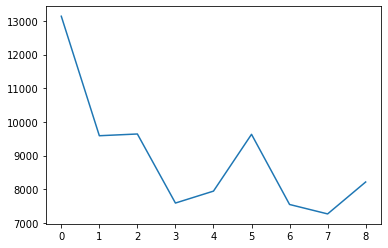

In [68]:
bic_s = bic(scores)
plt.plot(bic_s[1:])

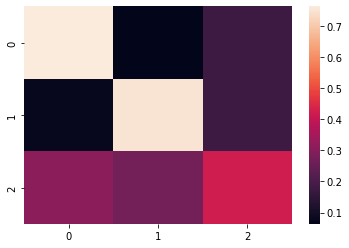

In [58]:
model = hmm.MultinomialHMM(n_components=3)
red_time_ser = red_time_ser.reshape(-1, 1)
model.fit(red_time_ser)
result = model.predict(red_time_ser)
ax = sns.heatmap(model.transmat_)
fig = ax.get_figure()
fig.savefig("Zika_HMM.png", dpi=300)